# Purpose

Investigate how this code works and learn how to save data for each time step so it can be imported and viewed in ParaView.

[Crank–Nicolson method](https://en.wikipedia.org/wiki/Crank–Nicolson_method)

Avoid spurious decaying oscillations in the solution if $\frac{\Delta t K }{\Delta x^2} > \frac{1}{2}$. *For this reason,  whenever large time steps or high spatial resolution is necessary, the less accurate [Backward Euler method](https://en.wikipedia.org/wiki/Backward_Euler_method) is often used, which is both stable and immune to oscillations.*

# Imports

In [156]:
from math import ceil
from typing import Iterator, Tuple

import numpy as np
from scipy.sparse.linalg import splu

from skfem import *
from skfem.models.poisson import laplace, mass

import meshio

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from skfem.visuals.matplotlib import plot

# Main code

dt = 0.01
0.01, 0.956, -0.0000
0.02, 0.915, -0.0000


/var/folders/tv/5t3f3sm57dq1rdrd6cnz0j8h0000gp/T/ipykernel_8592/1569857845.py:60: UserWarning: frames=<generator object evolve at 0x17f7491c0> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = FuncAnimation(


0.03, 0.875, -0.0000
0.04, 0.837, -0.0000
0.05, 0.800, -0.0000
0.06, 0.765, -0.0000
0.07, 0.732, -0.0000
0.08, 0.700, -0.0000
0.09, 0.670, -0.0000
0.10, 0.640, -0.0000
0.11, 0.613, -0.0001
0.12, 0.586, -0.0001
0.13, 0.560, -0.0001
0.14, 0.536, -0.0001
0.15, 0.513, -0.0001
0.16, 0.490, -0.0001
0.17, 0.469, -0.0001
0.18, 0.448, -0.0001
0.19, 0.429, -0.0001
0.20, 0.410, -0.0001
0.21, 0.392, -0.0001
0.22, 0.375, -0.0001
0.23, 0.359, -0.0001
0.24, 0.343, -0.0001
0.25, 0.328, -0.0001
0.26, 0.314, -0.0001
0.27, 0.300, -0.0001
0.28, 0.287, -0.0001
0.29, 0.275, -0.0001
0.30, 0.263, -0.0001
0.31, 0.251, -0.0001
0.32, 0.240, -0.0001
0.33, 0.230, -0.0001
0.34, 0.220, -0.0001
0.35, 0.210, -0.0001
0.36, 0.201, -0.0001
0.37, 0.192, -0.0001
0.38, 0.184, -0.0001
0.39, 0.176, -0.0001
0.40, 0.168, -0.0001
0.41, 0.161, -0.0000
0.42, 0.154, -0.0000
0.43, 0.147, -0.0000
0.44, 0.141, -0.0000
0.45, 0.135, -0.0000
0.46, 0.129, -0.0000
0.47, 0.123, -0.0000


/Users/nordin/micromamba/envs/scikit-fem/lib/python3.12/site-packages/matplotlib/animation.py:1741: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


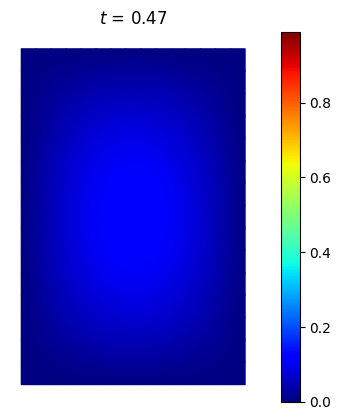

In [44]:
halfwidth = np.array([2., 3.])
ncells = 2**3
diffusivity = 5.

mesh = MeshQuad.init_tensor(
    np.linspace(-1, 1, 2 * ncells) * halfwidth[0],
    np.linspace(-1, 1, 2 * ncells * ceil(halfwidth[1] //
                                         halfwidth[0])) * halfwidth[1])

element = ElementQuad2()  # or ElementQuad1
basis = Basis(mesh, element)

L = diffusivity * asm(laplace, basis)
M = asm(mass, basis)

dt = .01
print('dt =', dt)
theta = 0.5                     # Crank–Nicolson
L0, M0 = penalize(L, M, D=basis.get_dofs())  # D=... -> Get all boundary DOFs
A = M0 + theta * L0 * dt
B = M0 - (1 - theta) * L0 * dt

backsolve = splu(A.T).solve  # .T as splu prefers CSC

u_init = np.cos(np.pi * basis.doflocs / 2 / halfwidth[:, None]).prod(0)


def exact(t: float) -> np.ndarray:
    return np.exp(-diffusivity * np.pi ** 2 * t / 4 * sum(halfwidth ** -2)) * u_init


def evolve(t: float, 
           u: np.ndarray) -> Iterator[Tuple[float, np.ndarray]]:

    while np.linalg.norm(u, np.inf) > 2**-3:
        t, u = t + dt, backsolve(B @ u)
        yield t, u


probe = basis.probes(np.zeros((mesh.dim(), 1)))

ax = plot(mesh, u_init[basis.nodal_dofs.flatten()], shading='gouraud')
title = ax.set_title('t = 0.00')
field = ax.get_children()[0]  # vertex-based temperature-colour
fig = ax.get_figure()
fig.colorbar(field)


def update(event):
    t, u = event

    u0 = {'skfem': (probe @ u)[0], 
          'exact': (probe @ exact(t))[0]}
    print('{:4.2f}, {:5.3f}, {:+7.4f}'.format(
            t, u0['skfem'], u0['skfem'] - u0['exact']))

    title.set_text(f'$t$ = {t:.2f}')
    field.set_array(u[basis.nodal_dofs.flatten()])

animation = FuncAnimation(
    fig,
    update,
    evolve(0., u_init),
    repeat=False,
    interval=50,
)

animation.save("movie.mp4")



# Generator function `evolve`

In [51]:
tt, uu = next(evolve(0., u_init))

In [53]:
uu.shape

(961,)

# Definitions of laplace and mass

`/Users/nordin/micromamba/envs/scikit-fem/lib/python3.12/site-packages/skfem/models/poisson.py`

```
"""Poisson equation."""

from skfem.assembly import BilinearForm, LinearForm
from skfem.helpers import grad, dot, ddot


@BilinearForm
def laplace(u, v, _):
    return dot(grad(u), grad(v))


@BilinearForm
def vector_laplace(u, v, _):
    return ddot(grad(u), grad(v))


@BilinearForm
def mass(u, v, _):
    return u * v


@LinearForm
def unit_load(v, _):
    return v
```

# Initial condition values

In [27]:
np.cos(np.pi * basis.doflocs / 2 / halfwidth[:, None]).prod(0).shape

(961,)

# L & M, L0 & M0 sparse matrices

In [28]:
L

<961x961 sparse matrix of type '<class 'numpy.float64'>'
	with 14641 stored elements in Compressed Sparse Row format>

In [16]:
M

<961x961 sparse matrix of type '<class 'numpy.float64'>'
	with 14641 stored elements in Compressed Sparse Row format>

In [29]:
L0

<961x961 sparse matrix of type '<class 'numpy.float64'>'
	with 14641 stored elements in Compressed Sparse Row format>

In [30]:
M0

<961x961 sparse matrix of type '<class 'numpy.float64'>'
	with 14641 stored elements in Compressed Sparse Row format>

# Probe

In [33]:
probe

<1x961 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in COOrdinate format>

In [34]:
np.zeros((mesh.dim(), 1))

array([[0.],
       [0.]])

In [35]:
basis.probes(np.zeros((mesh.dim(), 1)))

<1x961 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in COOrdinate format>

In [31]:
help(basis.probes)

Help on method probes in module skfem.assembly.basis.cell_basis:

probes(x: numpy.ndarray) method of skfem.assembly.basis.cell_basis.CellBasis instance
    Return matrix which acts on a solution vector to find its values
    on points `x`.

    The product of this with a finite element function vector is like the
    result of assembling a `Functional` and it can be thought of as the
    matrix of inner products of the test functions of the basis with Dirac
    deltas at `x` but because its action is concentrated at points it is
    not assembled with the usual quadratures.



In [56]:
tt, uu = next(evolve(0., u_init))
print(uu.shape)
probe @ uu

(961,)


array([0.95641913])

In [57]:
(probe @ uu)[0]

0.9564191327421183

## Bottom line

There is only one probe which is located at position 0,0 and which is used to extract the value of u at that location.

# penalize

In [11]:
help(penalize)

Help on function penalize in module skfem.utils:

penalize(A: scipy.sparse._matrix.spmatrix, b: Union[numpy.ndarray, scipy.sparse._matrix.spmatrix, NoneType] = None, x: Optional[numpy.ndarray] = None, I: Union[numpy.ndarray, skfem.assembly.dofs.DofsView, Dict[str, skfem.assembly.dofs.DofsView], NoneType] = None, D: Union[numpy.ndarray, skfem.assembly.dofs.DofsView, Dict[str, skfem.assembly.dofs.DofsView], NoneType] = None, epsilon: Optional[float] = None, overwrite: bool = False) -> Union[scipy.sparse._matrix.spmatrix, Tuple[scipy.sparse._matrix.spmatrix, numpy.ndarray], Tuple[scipy.sparse._matrix.spmatrix, scipy.sparse._matrix.spmatrix]]
    Penalize degrees-of-freedom of a linear system.

    Parameters
    ----------
    A
        The system matrix
    b
        Optionally, the right hand side vector.
    x
        The values of the penalized degrees-of-freedom. If not given, assumed
        to be zero.
    I
        Specify either this or ``D``: The set of degree-of-freedom indices

# Mesh

## mesh itself

<skfem MeshQuad1 object>
  Number of elements: 225
  Number of vertices: 256
  Number of nodes: 256
  Named boundaries [# facets]: left [15], bottom [15], right [15], top [15]


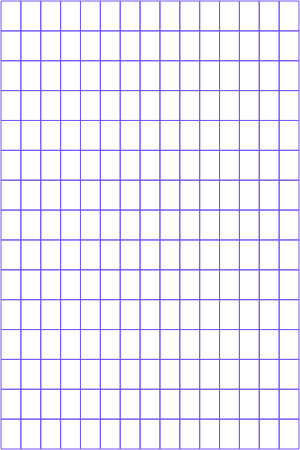

In [18]:
print(mesh)
mesh

In [73]:
# number of elements in mesh (count from above)
15 * 15

225

In [74]:
# number of vertices (count from above)
15 * 15 + (16 + 15)

256

In [70]:
mesh.nelements

225

In [71]:
mesh.nvertices

256

In [76]:
mesh.nnodes  # This must be the number of nodes for each element -> Quad must be specified by 4 nodes

4

In [32]:
mesh.dim()

2

In [64]:
print(basis)

<skfem CellBasis(MeshQuad1, ElementQuad2) object>
  Number of elements: 225
  Number of DOFs: 961
  Size: 1215000 B


## Set up coordinates for mesh

In [10]:
halfwidth = np.array([2., 3.])
ncells = 2**3
diffusivity = 5.

print(f"{np.linspace(-1, 1, 2 * ncells) * halfwidth[0]}")
print(f"{np.linspace(-1, 1, 2 * ncells * ceil(halfwidth[1] // halfwidth[0])) * halfwidth[1]}")


[-2.         -1.73333333 -1.46666667 -1.2        -0.93333333 -0.66666667
 -0.4        -0.13333333  0.13333333  0.4         0.66666667  0.93333333
  1.2         1.46666667  1.73333333  2.        ]
[-3.  -2.6 -2.2 -1.8 -1.4 -1.  -0.6 -0.2  0.2  0.6  1.   1.4  1.8  2.2
  2.6  3. ]


In [6]:
ceil(halfwidth[1] // halfwidth[0])

1

In [7]:
halfwidth[1] // halfwidth[0]

1.0

In [8]:
halfwidth[1] / halfwidth[0]

1.5

# Save field for each time step and save to file

## Compute fields for several time steps and save in an arrays

### How to use generator function

In [112]:
def evolve3(t: float, 
           u: np.ndarray) -> Iterator[Tuple[float, np.ndarray]]:

    while np.linalg.norm(u, np.inf) > 2**-3:
        t, u = t + dt, backsolve(B @ u)
        yield t, u

tt, uu = next(evolve3(0., u_init))
print(tt)
tt, uu = next(evolve3(tt, uu))
print(tt)
tt, uu = next(evolve3(tt, uu))
print(tt)

0.01
0.02
0.03


## Create data for multiple time steps

In [113]:
def evolve2(t: float, 
           u: np.ndarray) -> Iterator[Tuple[float, np.ndarray]]:

    while np.linalg.norm(u, np.inf) > 2**-3:
        t, u = t + dt, backsolve(B @ u)
        yield t, u

times = [0.0]
field_over_time = [u_init]


for i in range(5):
    if i == 0:
        tt, uu = next(evolve2(0., u_init))
    else:
        tt, uu = next(evolve2(tt, uu))
    print(tt)
    times.append(tt)
    field_over_time.append(uu)

times = np.array(times)
field_over_time = np.array(field_over_time)
field_over_time.shape

0.01
0.02
0.03
0.04
0.05


(6, 961)

In [114]:
times.shape

(6,)

## Save to VTK file - single time step

Note that there are 961 values in `uu`, but there are only 256 mesh vertices. The first 256 values in `uu` are the vertex values, the rest are various derivatives.

In [115]:
mesh.save("temp1.vtk", point_data={"solution": field_over_time[0,:mesh.nvertices]})

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

## Save to VTK file - all time steps

In [104]:
data_dict = {}
for i in range(len(times)):
    print(i, times[i])
    data_dict[times[i]] = field_over_time[i,:mesh.nvertices]

0 0.0
1 0.01
2 0.01
3 0.01
4 0.01
5 0.01


In [129]:
data_dict = {}
count = 0
for time, field in zip(times, field_over_time):
    data_dict[str(time)] = field[:mesh.nvertices]
    print(count, str(time))
    count += 1

0 0.0
1 0.01
2 0.02
3 0.03
4 0.04
5 0.05


In [131]:
data_dict["0.01"].shape

(256,)

In [133]:
mesh.save("temp2.xdmf", point_data=data_dict)

In [136]:
for i in range(6):
    print(f"hey {i:02d}")

hey 00
hey 01
hey 02
hey 03
hey 04
hey 05


In [137]:
count = 0
for time, field in zip(times, field_over_time):
    mesh.save(f"int_name_f{count:02d}.vtk", point_data={"solution": field[:mesh.nvertices]})
    print(count, str(time))
    count += 1



Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

0 0.0


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

1 0.01


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

2 0.02


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

3 0.03


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

4 0.04


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

5 0.05


In [145]:
for i in np.linspace(0.0, 0.1, 11):
    print(f"hey again {i:0.2f}")

hey again 0.00
hey again 0.01
hey again 0.02
hey again 0.03
hey again 0.04
hey again 0.05
hey again 0.06
hey again 0.07
hey again 0.08
hey again 0.09
hey again 0.10


In [146]:
for time, field in zip(times, field_over_time):
    mesh.save(f"time_name_f{time:0.2f}.vtk", point_data={"solution": field[:mesh.nvertices]})
    print(time)


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

0.0


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

0.01


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

0.02


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

0.03


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

0.04


Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

0.05


In [155]:
for i in np.linspace(0.0, 0.0001, 11):
    print(f"hey again {i:.2g}")

hey again 0
hey again 1e-05
hey again 2e-05
hey again 3e-05
hey again 4e-05
hey again 5e-05
hey again 6e-05
hey again 7e-05
hey again 8e-05
hey again 9e-05
hey again 0.0001


In [ ]:
for time, field in zip(times, field_over_time):
    mesh.save(f"time_name_g{time:0.2g}.vtk", point_data={"solution": field[:mesh.nvertices]})
    print(time)


## XDMF file with meshio

[meshio - time series data in an XDMF file](https://github.com/kinnala/scikit-fem?tab=readme-ov-file).